In [1]:
import numpy as np
import numpy.linalg as lin
import numpy.random as npr 
import scipy.optimize as sco
import scipy.stats as si 
import time
from scipy import interpolate 
from scipy.linalg import expm
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

In [2]:
# Parameter Input
S0 = 100.0 # ini stock price
G = 100.0 # garantee level
T = 10 # maturity
m = 0.02 # R&E fee
me = 0.01651366493609785 # rider charge for GMMB
md = 0.0009981174275268288 # rider charge for GMDB
N, X = 1024, 7.5 # FST param.
I, Path = 100000, 2000 # Monte Carlo param.

r = [0.04, 0.01] # risk-free interest rate
drift = [0.05, 0.02] # drift
sigma = [0.1, 0.2] # volatility
lamb = [0.1, 0.2]
mu = [0.2, -0.1] # jump mean
nu = [0.1, 0.2] # jump volatility

A = np.array([[-0.4, 0.4], [0.3, -0.3]]) # transition matrix
Pi = np.array([[1-0.9999], [1-0.0001]]) # ini state

In [3]:
# np.exp(mu[0] + 0.5 * nu[0] ** 2) - 1

0.2275250649631777

In [4]:
# np.exp(mu[1] + 0.5 * nu[1] ** 2) - 1

-0.07688365361336424

In [3]:
# PV of Zero-coupon bond
def z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    return float(Z)
# Rho1 of Zero-coupon bond
def rho1_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = -np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One))) / 100
    return float(Z)
# Rho2 of Zero-coupon bond
def rho2_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z1 = np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One)))
    Z2 = -T * np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    Z = (Z1 + Z2) / 100
    return float(Z)
print('z(10) = %.16f' % z(r, T, A, Pi)) # 0.7784180374597731
print('rho1_z(10) = %.16f' % rho1_z(r, T, A, Pi)) # -0.0778336802081909
print('rho2_z(10) = %.16f' % rho2_z(r, T, A, Pi)) # -0.0000081235377864

z(10) = 0.8123503847285959
rho1_z(10) = -0.0000077841464355
rho2_z(10) = -0.0812272543264241


In [4]:
# Stochastic Motality Risk
def b(t):
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    B = (1 - np.exp(b * t)) / (c + d * np.exp(b * t))
    return B
def s(t):
    ini = 0.00495 # aged 50 years old in 2017
    # ini = 0.01164 # aged 60 years old in 2017
    # ini = 0.02255 # aged 70 years old in 2017
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    # A = 0
    # S_feller = np.exp(A + B(t)*ini)
    S = np.exp((1 - np.exp(b * t)) / (c + d * np.exp(b * t)) * ini)
    return S
print('s(0) = %.16f' % s(0)) # 1.0
print('s(10) = %.16f' % s(15)) # 0.8672053048004046

s(0) = 1.0000000000000000
s(10) = 0.8672053048004046


In [33]:
def rsmjd_gmmb_mc(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, I):
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    l1, l2 = A[0, 1], A[1, 0]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    if Pi[0] > Pi[1]:
        Ini_State = 1.0
    else:
        Ini_State = 2.0
    F = np.zeros((T + 1, I))
    F[0] = S0
    cf = np.zeros((T + 1, I)) 
    for t in range(T + 1):
        for i in range(I):
            LogStock = float(np.log(S0))
            Cur_Time = 0.0
            Cur_State = Ini_State
            tau1 = 0.0
            while Cur_Time < t:
                p = npr.uniform(0, 1)
                if Cur_State == 1:
                    ExpRV = -1 * np.log(p) / l1
                else:
                    ExpRV = -1 * np.log(p) / l2
                if Cur_Time + ExpRV < t and Cur_State == 1:
                    tau1 = tau1 + ExpRV
                else:
                    if Cur_State == 1:
                        tau1 = tau1 + t - Cur_Time
                Cur_Time = Cur_Time + ExpRV
                if Cur_State == 1:
                    Cur_State = 2
                else:
                    Cur_State = 1
            J1 = 0
            Nt1 = npr.poisson(lamb1 * tau1)
            if Nt1 > 0:
                for j1 in range(Nt1):
                    J1 = J1 + npr.normal(mu1, nu1)
            J2 = 0
            Nt2 = npr.poisson(lamb2 * (t - tau1))
            if Nt2 > 0:
                for j2 in range(Nt2):
                    J2 = J2 + npr.normal(mu2, nu2)
            SimRand = float(npr.standard_normal())
            LogFund = LogStock + drift1 * tau1 + drift2 * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2) + J1 + J2
            F[t, i] = np.exp(LogFund)
            if t < T:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.exp(LogFund) * me * s(t)
            else:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.maximum(0, G - np.exp(LogFund))
    Gmmb_mean = np.mean(s(T) * cf[-1] - np.sum(cf[:-1], 0))
    Gmmb_std = np.std(s(T) * cf[-1] - np.sum(cf[:-1], 0))
    return (np.mean(cf[-1]), Gmmb_mean, Gmmb_std)

start = time.clock()
Results = rsmjd_gmmb_mc(S0, G, T, r, sigma, m, 0.016513664936097145, lamb, mu, nu, A, Pi, I)
# print('Put_MC = %.16f' % Results[0]) # 15.8974221895861056
print('GMMB_mean = %.16f' % Results[1]) # 0.0358920927391137
print('GMMB_std = %.16f' % Results[2])
elapsed = (time.clock() - start)
print("Time used:", elapsed)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
GMMB_mean = 0.0220445688395838
GMMB_std = 6.8129506271062006
Time used: 239.9529032999999
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [130]:
me_50 = np.array([0.016513664936097145, 0.012267996117903725, 0.009291599202270085, 0.006955260628422284, 0.0050156623208592105, 0.0033980548566261326])

train_sizes = np.array([10, 15, 20, 25, 30, 35])
test_mean = np.array([0.0287837107011552, -5.2766909383902387, -11.1528595579968091, -17.0575525881692833, -22.6930182015985800, -27.5758407539901427])
test_std = np.array([17.7713214962785138, 17.3197663267522302, 15.5850819989185396, 13.1187517024687175, 10.4670066977034324, 7.9849627319471619])

test_mean + 1.96 * test_std / np.sqrt(100000)
# test_mean = np.array([0.0287837107011552, 0.0391907971389868, 0.05792157120799491, 0.0163651819512721, 0.0581699469118219, 0.0220445688395838])
# test_std = np.array([17.7713214962785138, 17.2458290050018945, 15.3533771269227444, 12.6938279543221668, 9.7463159356472477, 6.8129506271062006])

array([  0.1389315 ,  -5.16934191, -11.05626222, -16.97624172,
       -22.62814302, -27.52634944])

In [142]:
def rsmjd_gmdb_mc(S0, G, T, r, sigma, m, md, lamb, mu, nu, A, Pi, I):
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    l1, l2 = A[0, 1], A[1, 0]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    if Pi[0] > Pi[1]:
        Ini_State = 1.0
    else:
        Ini_State = 2.0
    F = np.zeros((T + 1, I))
    F[0] = S0
    cf = np.zeros((T, I)) 
    put = np.zeros((T, I))
    for t in range(T + 1):
        for i in range(I):
            LogStock = float(np.log(S0))
            Cur_Time = 0.0
            Cur_State = Ini_State
            tau1 = 0.0
            while Cur_Time < t:
                p = npr.uniform(0, 1)
                if Cur_State == 1:
                    ExpRV = -1 * np.log(p) / l1
                else:
                    ExpRV = -1 * np.log(p) / l2
                if Cur_Time + ExpRV < t and Cur_State == 1:
                    tau1 = tau1 + ExpRV
                else:
                    if Cur_State == 1:
                        tau1 = tau1 + t - Cur_Time
                Cur_Time = Cur_Time + ExpRV
                if Cur_State == 1:
                    Cur_State = 2
                else:
                    Cur_State = 1
            J1 = 0
            Nt1 = npr.poisson(lamb1 * tau1)
            if Nt1 > 0:
                for j1 in range(Nt1):
                    J1 = J1 + npr.normal(mu1, nu1)
            J2 = 0
            Nt2 = npr.poisson(lamb2 * (t - tau1))
            if Nt2 > 0:
                for j2 in range(Nt2):
                    J2 = J2 + npr.normal(mu2, nu2)
            SimRand = float(npr.standard_normal())
            LogFund = LogStock + drift1 * tau1 + drift2 * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2) + J1 + J2
            F[t, i] = np.exp(LogFund)
            if t < T:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.exp(LogFund) * md * s(t)
            if 0 < t <= T:
                put[t-1, i] = (s(t-1) - s(t)) * np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.maximum(0, G - np.exp(LogFund))
    
    Gmdb_mean = np.mean(np.sum(put, 0) - np.sum(cf[:-1], 0))
    Gmdb_std = np.std(np.sum(put, 0) - np.sum(cf[:-1], 0))
    return (Gmdb_mean, Gmdb_std) 

#start = time.clock()
Results = rsmjd_gmdb_mc(S0, G, 35, r, sigma, m, 0.0009981174275267945, lamb, mu, nu, A, Pi, 1000)
# print('Put_MC = %.16f' % Results[0]) # 15.8974221895861056
print('GMDB_mean = %.16f' % Results[0]) # 0.0358920927391137
print('GMDB_std = %.16f' % Results[1])
#elapsed = (time.clock() - start)
#print("Time used:", elapsed)

GMDB_mean = 7.9116937053080276
GMDB_std = 2.0513317894498528


In [147]:
time = [64.00729489999867, 108.995432599997, 147.87937020000027, 218.42004280000037, 278.8988296000025, 360.5946054999986]

test_mean = np.array([0.0625403275839971, 0.7263823369086750, 1.9051716623159050, 3.5476073099805210, 5.5227441172108813, 7.8531558664243644])
test_std = np.array([0.4451886626147721, 0.7516990471038192, 1.1079206522207801, 1.4734948010090994, 1.9003635052746497, 2.0513317894498528])

test_mean + 1.96 * test_std / np.sqrt(100000)

array([0.06529964, 0.73104142, 1.91203863, 3.55674013, 5.53452269,
       7.86587015])

## GMMB

In [16]:
def rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    p1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    p2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, p1)
    f2 = interpolate.PchipInterpolator(ST, p2)
    P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(P) # 15.8587171702497667

start = time.clock()
print('Put_FST = %.16f' % rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))
elapsed = (time.clock() - start)
print("Time used:", elapsed)

Put_FST = 15.8587171702497702
Time used: 0.2763305000000287


In [37]:
# def rsmjd_call_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
#     # parameter
#     r1, r2 = r[0], r[1]
#     sigma1, sigma2 = sigma[0], sigma[1]
#     A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
#     mu1, mu2 = mu[0], mu[1]
#     nu1, nu2 = nu[0], nu[1]
#     lamb1, lamb2 = lamb[0], lamb[1]
#     # Real space
#     x_min, x_max = -X, X
#     dx = (x_max - x_min) / (N - 1)
#     x = np.linspace(x_min, x_max, N)
#     # Fourier space
#     epsilon = 0.0001
#     w_max = np.pi / dx
#     dw = 2 * w_max / N
#     w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
#     # Payoff function at time T
#     ST = S0 * np.exp(x)
#     payoff_c = np.maximum(ST - G, 0)
#     # Matrix characteristic funciton
#     drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
#     drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
#     psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
#     psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
#     Psi = np.zeros((N, 2, 2), dtype=complex)
#     for i in range(N):
#         Psi[i, 0] = [A11 + psi1[i], A12]
#         Psi[i, 1] = [A21, A22 + psi2[i]]
#     char = np.array([expm(i * T) for i in Psi])
#     # FST method
#     c1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)).real
#     c2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)).real
#     # Interpolate prices
#     f1 = interpolate.PchipInterpolator(ST, c1)
#     f2 = interpolate.PchipInterpolator(ST, c2)
#     C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
#     return float(C) # 19.8899884685907864
# print('Call_FST = %.16f' % rsmjd_call_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))

In [17]:
def rsmjd_gmmb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    P = rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, re1)
        f2 = interpolate.PchipInterpolator(ST, re2)
        Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Re = np.sum(Re)
    # calculate GMMB loss
    Loss = s(T) * P - Re
    return float(Loss)  # 0.0000000000002878

start = time.clock()
print('GMMB_FST = %.16f' % rsmjd_gmmb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X))
elapsed = (time.clock() - start)
print("Time used:", elapsed)

#me = np.array([0.016513664936097145, 0.012267996117903725, 0.009291599202270085, 0.006955260628422284, 0.0050156623208592105, 0.0033980548566261326])

GMMB_FST = -0.0000000000005418
Time used: 3.111496700000032


0.00023873841209805

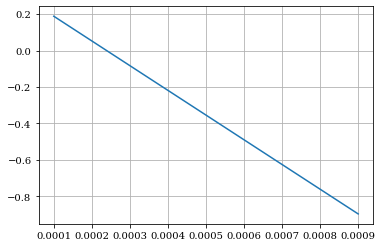

In [62]:
# # Fair Rates (m, me)
# me = np.linspace(0.0001, 0.0009, 20)
# loss = []
# for i in me:
#     temp = rsmjd_gmmb_fst(S0, G, 35, r, sigma, m, i, lamb, mu, nu, A, Pi, N, X)
#     loss.append(temp)
# plt.plot(me, loss)
# plt.grid()
# f = interpolate.PchipInterpolator(loss[::-1], me[::-1])
# me = f(0) # fair rate of me
# float(me) # 0.01651366493609785

In [ ]:
# me_50 = np.array([0.016513664936097145, 0.012267996117903725, 0.009291599202270085, 0.006955260628422284, 0.0050156623208592105, 0.0033980548566261326])
# me_70 = np.array([0.013881269459352133, 0.008692143810045204, 0.005002764583046773, 0.0024360498078331233, 0.0009143086355714936, 0.00023873841209805])

## GMDB

In [19]:
def rsmjd_gmdb_fst(S0, G, T, r, sigma, m, md, lamb, mu, nu, A, Pi, N, X):
    Be = []
    for t in range(1, T+1):
        P = (s(t-1) - s(t)) * rsmjd_put_fst(S0, G, t, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
        Be.append(P)
    Be = np.sum(Be)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = md * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, re1)
        f2 = interpolate.PchipInterpolator(ST, re2)
        Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Re = np.sum(Re)
    # calculate GMMB loss
    Loss = Be - Re
    return float(Loss)  # 0.0000000000002878

#print('GMDB_FST = %.16f' % rsmjd_gmdb_fst(S0, G, 20, r, sigma, m, 0.0009981174275267945, lamb, mu, nu, A, Pi, N, X))

start = time.clock()
print('GMDB_FST = %.16f' % rsmjd_gmdb_fst(S0, G, T, r, sigma, m, md, lamb, mu, nu, A, Pi, N, X))
elapsed = (time.clock() - start)
print("Time used:", elapsed)

GMDB_FST = -0.0000000000000366
Time used: 5.713215199999922


In [105]:
# # Fair Rates (m, me)
# md = np.linspace(0.0001, 0.02, 50)
# loss = []
# for i in md:
#     temp = rsmjd_gmdb_fst(S0, G, 10, r, sigma, m, i, lamb, mu, nu, A, Pi, N, X)
#     loss.append(temp)
# plt.plot(md, loss)
# plt.grid()
# f = interpolate.PchipInterpolator(loss[::-1], md[::-1])
# md = f(0) # fair rate of md
# float(md) # 0.0009981174275268288

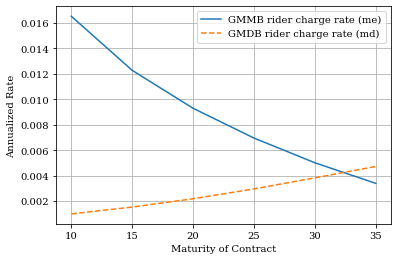

In [7]:
# # 50 years old
# years = np.array([10, 15, 20, 25, 30, 35])
# me_50 = np.array([0.016513664936097145, 0.012267996117903725, 0.009291599202270085, 0.006955260628422284, 0.0050156623208592105, 0.0033980548566261326])
# md_50 = np.array([0.0009981174275267945, 0.0015348741348631405, 0.002187737813435453, 0.0029606631920710332, 0.003827069985384454, 0.004720776860324511])
# sty = ['-', '--']
# plt.plot(years, me_50, label='GMMB rider charge rate (me)', linestyle=sty[0])
# plt.plot(years, md_50, label='GMDB rider charge rate (md)', linestyle=sty[1])
# plt.legend()
# plt.ylabel('Annualized Rate')
# plt.xlabel('Maturity of Contract')
# plt.grid()

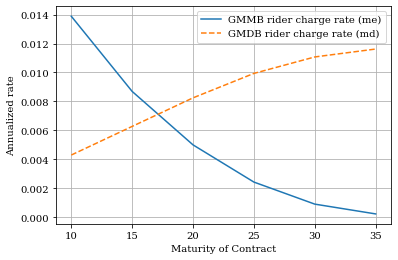

In [8]:
# # 70 years old
# years = np.array([10, 15, 20, 25, 30, 35])
# me_70 = np.array([0.013881269459352133, 0.008692143810045204, 0.005002764583046773, 0.0024360498078331233, 0.0009143086355714936, 0.00023873841209805])
# md_70 = np.array([0.004302780979745228, 0.006279167140136166, 0.008249672010876393, 0.009936017102623604, 0.011071987339808171, 0.011618115476638428])
# sty = ['-', '--']
# plt.plot(years, me_70, label='GMMB rider charge rate (me)', linestyle=sty[0])
# plt.plot(years, md_70, label='GMDB rider charge rate (md)', linestyle=sty[1])
# plt.legend()
# plt.ylabel('Annualized rate')
# plt.xlabel('Maturity of Contract')
# plt.grid()

## Guarantee level & Maturity (50 years old)

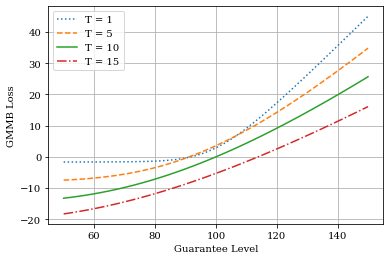

In [87]:
# # 50 years old
# guarantee = np.linspace(50, 150)
# time = [1, 5, 10, 15]
# lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
# sty = [':', '--', '-', '-.']
# # plt.figure(figsize=(10,6))
# for j in range(len(time)):
#     v = []
#     for i in guarantee:
#         temp = rsmjd_gmmb_fst(S0, i, time[j], r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#         v.append(temp)
#     plt.plot(guarantee, v, label=lab[j], linestyle=sty[j])
# plt.legend()
# plt.xlabel('Guarantee Level')
# plt.ylabel('GMMB Loss')
# plt.grid()

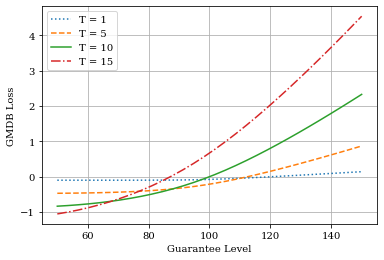

In [20]:
# 50 years old GMDB
guarantee = np.linspace(50, 150, 30)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
# plt.figure(figsize=(10,6))
for j in range(len(time)):
    v = []
    for i in guarantee:
        temp = rsmjd_gmdb_fst(S0, i, time[j], r, sigma, m, md, lamb, mu, nu, A, Pi, N, X)
        v.append(temp)
    plt.plot(guarantee, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Guarantee Level')
plt.ylabel('GMDB Loss')
plt.grid()

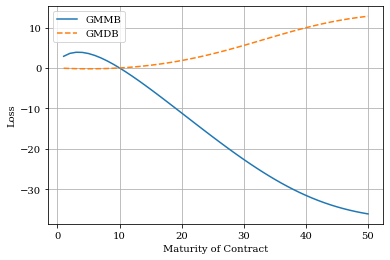

In [93]:
# maturity = np.arange(1, 51)
# lab = ['GMMB', 'GMDB']
# sty = ['-', '--']
# # plt.figure(figsize=(10,6))
# gmmb = []
# gmdb = []
# for i in maturity:
#     temp1 = rsmjd_gmmb_fst(S0, G, i, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     gmmb.append(temp1)
#     temp2 = rsmjd_gmdb_fst(S0, G, i, r, sigma, m, md, lamb, mu, nu, A, Pi, N, X)
#     gmdb.append(temp2)  
# plt.plot(maturity, gmmb, label=lab[0], linestyle=sty[0])
# plt.plot(maturity, gmdb, label=lab[1], linestyle=sty[1])
# plt.legend()
# plt.xlabel('Maturity of Contract')
# plt.ylabel('Loss')
# plt.grid()

## Guarantee level & Maturity (70 years old)

In [11]:
# me = 0.013881269459352473
# md = 0.004302780979745348

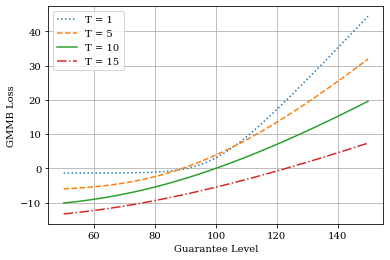

In [12]:
# 50 years old
# guarantee = np.linspace(50, 150)
# time = [1, 5, 10, 15]
# lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
# sty = [':', '--', '-', '-.']
# # plt.figure(figsize=(10,6))
# for j in range(len(time)):
#     v = []
#     for i in guarantee:
#         temp = rsmjd_gmmb_fst(S0, i, time[j], r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#         v.append(temp)
#     plt.plot(guarantee, v, label=lab[j], linestyle=sty[j])
# plt.legend()
# plt.xlabel('Guarantee Level')
# plt.ylabel('GMMB Loss')
# plt.grid()

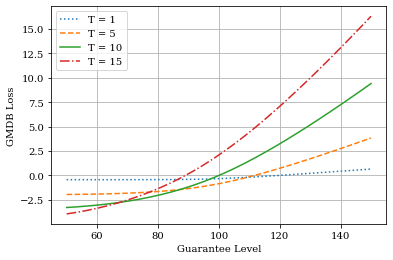

In [22]:
# 70 years old GMDB
guarantee = np.linspace(50, 150, 30)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
# plt.figure(figsize=(10,6))
for j in range(len(time)):
    v = []
    for i in guarantee:
        temp = rsmjd_gmdb_fst(S0, i, time[j], r, sigma, m,0.004302780979745228, lamb, mu, nu, A, Pi, N, X)
        v.append(temp)
    plt.plot(guarantee, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Guarantee Level')
plt.ylabel('GMDB Loss')
plt.grid()

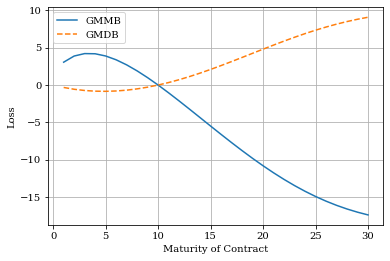

In [13]:
# maturity = np.arange(1, 31)
# lab = ['GMMB', 'GMDB']
# sty = ['-', '--']
# # plt.figure(figsize=(10,6))
# gmmb = []
# gmdb = []
# for i in maturity:
#     temp1 = rsmjd_gmmb_fst(S0, G, i, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     gmmb.append(temp1)
#     temp2 = rsmjd_gmdb_fst(S0, G, i, r, sigma, m, md, lamb, mu, nu, A, Pi, N, X)
#     gmdb.append(temp2)  
# plt.plot(maturity, gmmb, label=lab[0], linestyle=sty[0])
# plt.plot(maturity, gmdb, label=lab[1], linestyle=sty[1])
# plt.legend()
# plt.xlabel('Maturity of Contract')
# plt.ylabel('Loss')
# plt.grid()

## 3D plot

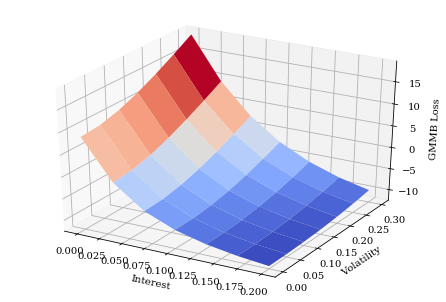

In [11]:
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = Axes3D(fig)

# interest1 = np.linspace(0, 0.2, num=7)
# vol1 = np.linspace(0, 0.3, num=7)
# interest1, vol1 = np.meshgrid(interest1, vol1)
# v = np.zeros_like(interest1)

# for i in range(7): 
#     for j in range(7):
#         interest = [interest1[i, j], r[1]]
#         vol = [vol1[i, j], sigma[1]]
#         v[i, j] = rsmjd_gmmb_fst(S0, G, T, interest, vol, m, me, lamb, mu, nu, A, Pi, N, X)

# surf = ax.plot_surface(interest1, vol1, v, cmap=plt.cm.coolwarm)
# ax.set_xlabel('Interest')
# ax.set_ylabel('Volatility')
# ax.set_zlabel('GMMB Loss') 
# plt.show()

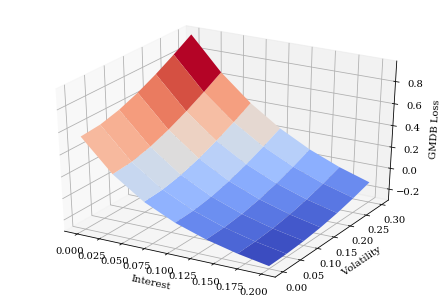

In [158]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

interest1 = np.linspace(0, 0.2, num=7)
vol1 = np.linspace(0, 0.3, num=7)
interest1, vol1 = np.meshgrid(interest1, vol1)
v = np.zeros_like(interest1)

for i in range(7): 
    for j in range(7):
        interest = [interest1[i, j], r[1]]
        vol = [vol1[i, j], sigma[1]]
        v[i, j] = rsmjd_gmdb_fst(S0, G, T, interest, vol, m, md, lamb, mu, nu, A, Pi, N, X)

surf = ax.plot_surface(interest1, vol1, v, cmap=plt.cm.coolwarm)
ax.set_xlabel('Interest')
ax.set_ylabel('Volatility')
ax.set_zlabel('GMDB Loss') 
plt.show()

## Delta

In [8]:
def rsmjd_putdelta_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    delta_p1 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)) / (ST)).real
    delta_p2 = (ifft(1j * w * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)) / (ST)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, delta_p1)
    f2 = interpolate.PchipInterpolator(ST, delta_p2)
    Delta_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(Delta_P) # -0.2892064937563866
print('Delta_Put = %.16f' % rsmjd_putdelta_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))

Delta_Put = -0.2851798089966586


In [16]:
# def rsmjd_calldelta_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
#     # parameter
#     r1, r2 = r[0], r[1]
#     sigma1, sigma2 = sigma[0], sigma[1]
#     A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
#     mu1, mu2 = mu[0], mu[1]
#     nu1, nu2 = nu[0], nu[1]
#     lamb1, lamb2 = lamb[0], lamb[1]
#     # Real space
#     x_min, x_max = -X, X
#     dx = (x_max - x_min) / (N - 1)
#     x = np.linspace(x_min, x_max, N)
#     # Fourier space
#     epsilon = 0.0001
#     w_max = np.pi / dx
#     dw = 2 * w_max / N
#     w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
#     # Payoff function at time T
#     ST = S0 * np.exp(x)
#     payoff_c = np.maximum(ST - G, 0)
#     # Matrix characteristic funciton
#     drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
#     drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
#     psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
#     psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
#     Psi = np.zeros((N, 2, 2), dtype=complex)
#     for i in range(N):
#         Psi[i, 0] = [A11 + psi1[i], A12]
#         Psi[i, 1] = [A21, A22 + psi2[i]]
#     char = np.array([expm(i * T) for i in Psi])
#     # FST method
#     delta_c1 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)) / (ST)).real
#     delta_c2 = (ifft(1j * w * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)) / (ST)).real
#     # Interpolate prices
#     f1 = interpolate.PchipInterpolator(ST, delta_c1)
#     f2 = interpolate.PchipInterpolator(ST, delta_c2)
#     Delta_C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
#     return float(Delta_C) # 0.5335509441376893
# print('Delta_Call = %.16f' % rsmjd_calldelta_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))

Delta_Call = 0.5335509441376893


In [9]:
def rsmjd_gmmbdelta_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Delta_P = rsmjd_putdelta_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Delta_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        delta_re1 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST)).real
        delta_re2 = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, delta_re1)
        f2 = interpolate.PchipInterpolator(ST, delta_re2)
        Delta_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Delta = s(T) * Delta_P - np.sum(Delta_Re)
    return float(Delta) # -0.4162717019499024
print('Delta_GMMB = %.16f' % rsmjd_gmmbdelta_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X))

Delta_GMMB = -0.4162717019499024


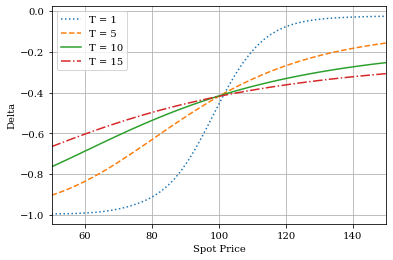

In [11]:
# spot = np.linspace(50, 150)
# time = [1, 5, 10, 15]
# lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
# sty = [':', '--', '-', '-.']
# for j in range(len(time)):
#     v = []
#     for i in spot:
#         temp = rsmjd_gmmbdelta_fst(i, G, time[j], r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#         v.append(temp)
#     plt.plot(spot, v, label=lab[j], linestyle=sty[j])
# plt.legend()
# plt.xlabel('Spot Price')
# plt.xlim((50, 150))
# plt.ylabel('Delta')
# # plt.ylim((-1, 0))
# plt.grid()

## Gamma

In [10]:
def rsmjd_putgamma_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    gamma_p1 = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)) / (ST ** 2)).real
    gamma_p2 = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)) / (ST ** 2)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, gamma_p1)
    f2 = interpolate.PchipInterpolator(ST, gamma_p2)
    Gamma_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(Gamma_P) # 0.0055049515372804
print('Gamma_Put = %.16f' % rsmjd_putgamma_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))

Gamma_Put = 0.0055049515372804


In [19]:
# def rsmjd_callgamma_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
#     # parameter
#     r1, r2 = r[0], r[1]
#     sigma1, sigma2 = sigma[0], sigma[1]
#     A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
#     mu1, mu2 = mu[0], mu[1]
#     nu1, nu2 = nu[0], nu[1]
#     lamb1, lamb2 = lamb[0], lamb[1]
#     # Real space
#     x_min, x_max = -X, X
#     dx = (x_max - x_min) / (N - 1)
#     x = np.linspace(x_min, x_max, N)
#     # Real space
#     x_min, x_max = -X, X
#     dx = (x_max - x_min) / (N - 1)
#     x = np.linspace(x_min, x_max, N)
#     # Fourier space
#     epsilon = 0.0001
#     w_max = np.pi / dx
#     dw = 2 * w_max / N
#     w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
#     # Payoff function at time T
#     ST = S0 * np.exp(x)
#     payoff_c = np.maximum(ST - G, 0)
#     # Matrix characteristic funciton
#     drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
#     drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
#     psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
#     psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
#     Psi = np.zeros((N, 2, 2), dtype=complex)
#     for i in range(N):
#         Psi[i, 0] = [A11 + psi1[i], A12]
#         Psi[i, 1] = [A21, A22 + psi2[i]]
#     char = np.array([expm(i * T) for i in Psi])
#     # FST method
#     gamma_c1 = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)) / (ST ** 2)).real
#     gamma_c2 = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)) / (ST ** 2)).real
#     # Interpolate prices
#     f1 = interpolate.PchipInterpolator(ST, gamma_c1)
#     f2 = interpolate.PchipInterpolator(ST, gamma_c2)
#     Gamma_C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
#     return float(Gamma_C) # 0.0055049515372804
# print('Gamma_Call = %.16f' % rsmjd_callgamma_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))

Gamma_Call = 0.0055049515381239


In [11]:
def rsmjd_gmmbgamma_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Gamma_P = rsmjd_putgamma_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Gamma_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        gamma_re1 = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)) / (ST ** 2)).real
        gamma_re2 = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)) / (ST ** 2)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, gamma_re1)
        f2 = interpolate.PchipInterpolator(ST, gamma_re2)
        Gamma_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    # calculate GMMB delta
    Gamma = s(T) * Gamma_P - np.sum(Gamma_Re)
    return float(Gamma) # 0.0054177473770854
print('Gamma_GMMB = %.16f' % rsmjd_gmmbgamma_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X))

Gamma_GMMB = 0.0054177473770854


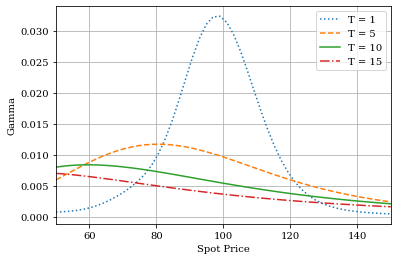

In [15]:
# spot = np.linspace(50, 150)
# time = [1, 5, 10, 15]
# lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
# sty = [':', '--', '-', '-.']
# for j in range(len(time)):
#     v = []
#     for i in spot:
#         temp = rsmjd_gmmbgamma_fst(i, G, time[j], r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#         v.append(temp)
#     plt.plot(spot, v, label=lab[j], linestyle=sty[j])
# plt.legend()
# plt.xlabel('Spot Price')
# plt.xlim((50, 150))
# plt.ylabel('Gamma')
# # plt.ylim((0, 0.035))
# plt.grid()

## Rho

In [12]:
def rsmjd_putrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for rho 1
    rho1_p1 = ifft((1j * w - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    rho1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, rho1_p1)
    f2 = interpolate.PchipInterpolator(ST, rho1_p2)
    Rho1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for rho 2
    rho2_p1 = ifft(0 * fft(payoff_p)).real
    rho2_p2 = ifft((1j * w - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, rho2_p1)
    f2 = interpolate.PchipInterpolator(ST, rho2_p2)
    Rho2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Rho1_P), float(Rho2_P))
Results = rsmjd_putrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
print('Rho1_Put = %.16f' % Results[0]) # -4.4371758355264328
print('Rho2_Put = %.16f' % Results[1]) # -0.0004939428560587

Rho1_Put = -4.4371758355264328
Rho2_Put = -0.0004939428560587


In [22]:
# def rsmjd_callrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
#     # parameter
#     r1, r2 = r[0], r[1]
#     sigma1, sigma2 = sigma[0], sigma[1]
#     A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
#     mu1, mu2 = mu[0], mu[1]
#     nu1, nu2 = nu[0], nu[1]
#     lamb1, lamb2 = lamb[0], lamb[1]
#     # Real space
#     x_min, x_max = -X, X
#     dx = (x_max - x_min) / (N - 1)
#     x = np.linspace(x_min, x_max, N)
#     # Fourier space
#     epsilon = 0.0001
#     w_max = np.pi / dx
#     dw = 2 * w_max / N
#     w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
#     # Payoff function at time T
#     ST = S0 * np.exp(x)
#     payoff_c = np.maximum(ST - G, 0)
#     # Matrix characteristic funciton
#     drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
#     drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
#     psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
#     psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
#     Psi = np.zeros((N, 2, 2), dtype=complex)
#     for i in range(N):
#         Psi[i, 0] = [A11 + psi1[i], A12]
#         Psi[i, 1] = [A21, A22 + psi2[i]]
#     char = np.array([expm(i * T) for i in Psi])
#     # FST method for rho 1
#     rho1_c1 = ifft((1j * w - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)).real
#     rho1_c2 = ifft(0 * fft(payoff_c)).real
#     # Interpolate prices
#     f1 = interpolate.PchipInterpolator(ST, rho1_c1)
#     f2 = interpolate.PchipInterpolator(ST, rho1_c2)
#     Rho1_C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
#     # FST method for rho 2
#     rho2_c1 = ifft(0 * fft(payoff_c)).real
#     rho2_c2 = ifft((1j * w - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)).real
#     # Interpolate prices
#     f1 = interpolate.PchipInterpolator(ST, rho2_c1)
#     f2 = interpolate.PchipInterpolator(ST, rho2_c2)
#     Rho2_C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
#     return (float(Rho1_C), float(Rho2_C))
# Results = rsmjd_callrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
# print('Rho1_Call = %.16f' % Results[0]) # 3.3461921856948957
# print('Rho2_Call = %.16f' % Results[1]) # 0.0003184109226159

Rho1_Call = 3.3461921856948957
Rho2_Call = 0.0003184109226159


In [13]:
def rsmjd_gmmbrho_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Rho1_P = rsmjd_putrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Rho2_P = rsmjd_putrho_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Rho1_Re = []
    Rho2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        rho1_re1 = ifft((1j * w - 1) * t * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        rho1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, rho1_re1)
        f2 = interpolate.PchipInterpolator(ST, rho1_re2)
        Rho1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method for sigma2
        rho2_re1 = ifft(0 * fft(payoff_r)).real
        rho2_re2 = ifft((1j * w - 1) * t * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, rho2_re1)
        f2 = interpolate.PchipInterpolator(ST, rho2_re2)
        Rho2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Rho1_Re = np.sum(Rho1_Re) / 100
    Rho2_Re = np.sum(Rho2_Re) / 100
    # calculate GMMB delta
    Rho1 = (s(T) * Rho1_P - Rho1_Re)
    Rho2 = (s(T) * Rho2_P - Rho2_Re)
    return (float(Rho1), float(Rho2))
Results = rsmjd_gmmbrho_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Rho1_GMMB = %.16f' % Results[0]) # -4.1139936030170290
print('Rho2_GMMB = %.16f' % Results[1]) # -0.0004579664690787

Rho1_GMMB = -4.1139936030170290
Rho2_GMMB = -0.0004579664690787


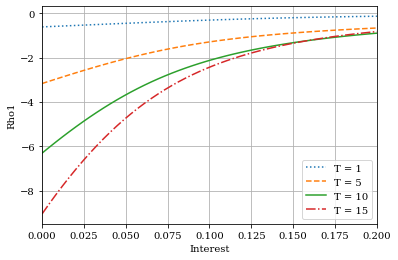

In [20]:
# rho1 = np.linspace(0, 0.2)
# time = [1, 5, 10, 15]
# lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
# sty = [':', '--', '-', '-.']
# for j in range(len(time)):
#     v = []
#     for i in rho1:
#         interest = [i, r[1]]
#         temp = rsmjd_gmmbrho_fst(S0, G, time[j], interest, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
#         v.append(temp)
#     plt.plot(rho1, v, label=lab[j], linestyle=sty[j])
# plt.legend()
# plt.xlabel('Interest')
# plt.xlim((0, 0.2))
# plt.ylabel('Rho1')
# plt.grid()

## Vega

In [14]:
def rsmjd_putvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    vega1_p1 = ifft(-(1j * w + w ** 2) * sigma1 * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    vega1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, vega1_p1)
    f2 = interpolate.PchipInterpolator(ST, vega1_p2)
    Vega1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    vega2_p1 = ifft(0 * fft(payoff_p)).real
    vega2_p2 = ifft(-(1j * w + w ** 2) * sigma2 * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, vega2_p1)
    f2 = interpolate.PchipInterpolator(ST, vega2_p2)
    Vega2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Vega1_P), float(Vega2_P))
Results = rsmjd_putvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X) 
print('Vega1_Put = %.16f' % Results[0]) # 0.5504435468784196
print('Vega2_Put = %.16f' % Results[1]) # 0.0001043104931637

Vega1_Put = 0.5504435468784196
Vega2_Put = 0.0001043104931637


In [25]:
# def rsmjd_callvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
#     # parameter
#     r1, r2 = r[0], r[1]
#     sigma1, sigma2 = sigma[0], sigma[1]
#     A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
#     mu1, mu2 = mu[0], mu[1]
#     nu1, nu2 = nu[0], nu[1]
#     lamb1, lamb2 = lamb[0], lamb[1]
#     # Real space
#     x_min, x_max = -X, X
#     dx = (x_max - x_min) / (N - 1)
#     x = np.linspace(x_min, x_max, N)
#     # Fourier space
#     epsilon = 0.0001
#     w_max = np.pi / dx
#     dw = 2 * w_max / N
#     w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
#     # Payoff function at time T
#     ST = S0 * np.exp(x)
#     payoff_c = np.maximum(ST - G, 0)
#     # Matrix characteristic funciton
#     drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
#     drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
#     psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
#     psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
#     Psi = np.zeros((N, 2, 2), dtype=complex)
#     for i in range(N):
#         Psi[i, 0] = [A11 + psi1[i], A12]
#         Psi[i, 1] = [A21, A22 + psi2[i]]
#     char = np.array([expm(i * T) for i in Psi])
#     # FST method for sigma 1
#     vega1_c1 = ifft(-(1j * w + w ** 2) * sigma1 * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)).real
#     vega1_c2 = ifft(0 * fft(payoff_c)).real
#     # Interpolate prices
#     f1 = interpolate.PchipInterpolator(ST, vega1_c1)
#     f2 = interpolate.PchipInterpolator(ST, vega1_c2)
#     Vega1_C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
#     # FST method for sigma 2
#     vega2_c1 = ifft(0 * fft(payoff_c)).real
#     vega2_c2 = ifft(-(1j * w + w ** 2) * sigma2 * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)).real
#     # Interpolate prices
#     f1 = interpolate.PchipInterpolator(ST, vega2_c1)
#     f2 = interpolate.PchipInterpolator(ST, vega2_c2)
#     Vega2_C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
#     return (float(Vega1_C), float(Vega2_C))
# Results = rsmjd_callvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X) 
# print('Vega1_Call = %.16f' % Results[0]) # 0.5504435468784196
# print('Vega2_Call = %.16f' % Results[1]) # 0.0001043104931637

Vega1_Call = 0.5504435469627400
Vega2_Call = 0.0001043104931832


In [15]:
def rsmjd_gmmbvega_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Vega1_P = rsmjd_putvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Vega2_P = rsmjd_putvega_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Vega1_Re = []
    Vega2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        vega1_re1 = ifft(-(1j * w + w ** 2) * sigma1 * t * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        vega1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, vega1_re1)
        f2 = interpolate.PchipInterpolator(ST, vega1_re2)
        Vega1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))           # FST method for sigma2
        vega2_re1 = ifft(0 * fft(payoff_r)).real
        vega2_re2 = ifft(-(1j * w + w ** 2) * sigma2 * t * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, vega2_re1)
        f2 = interpolate.PchipInterpolator(ST, vega2_re2)
        Vega2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Vega1_Re = np.sum(Vega1_Re) / 100
    Vega2_Re = np.sum(Vega2_Re) / 100
    # calculate GMMB delta
    Vega1 = (s(T) * Vega1_P - Vega1_Re)
    Vega2 = (s(T) * Vega2_P - Vega2_Re)
    return (float(Vega1), float(Vega2))
Results = rsmjd_gmmbvega_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Vega1_GMMB = %.16f' % Results[0]) # 0.5103519253169398
print('Vega2_GMMB = %.16f' % Results[1]) # 0.0000967130259199

Vega1_GMMB = 0.5103519253169398
Vega2_GMMB = 0.0000967130259199


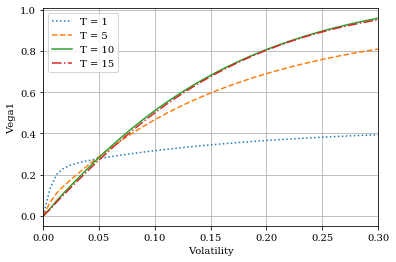

In [23]:
# vol1 = np.linspace(0, 0.3)
# time = [1, 5, 10, 15]
# lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
# sty = [':', '--', '-', '-.']
# for j in range(len(time)):
#     v = []
#     for i in vol1:
#         vol = [i, sigma[1]]
#         temp = rsmjd_gmmbvega_fst(S0, G, time[j], r, vol, m, me, lamb, mu, nu, A, Pi, N, X)[0]
#         v.append(temp)
#     plt.plot(vol1, v, label=lab[j], linestyle=sty[j])
# plt.legend()
# plt.xlabel('Volatility')
# plt.xlim((0, 0.3))
# plt.ylabel('Vega1')
# plt.grid()

## Lamb

In [152]:
def rsmjd_putlamb_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    lamb1_p1 = ifft((-1j * w * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) + np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    lamb1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, lamb1_p1)
    f2 = interpolate.PchipInterpolator(ST, lamb1_p2)
    Lamb1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    lamb2_p1 = ifft(0 * fft(payoff_p)).real
    lamb2_p2 = ifft((-1j * w * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) + np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, lamb2_p1)
    f2 = interpolate.PchipInterpolator(ST, lamb2_p2)
    Lamb2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Lamb1_P), float(Lamb2_P))
Results = rsmjd_putlamb_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X) 
print('Lamb1_Put = %.16f' % Results[0]) # 0.1511416152160739
print('Lamb2_Put = %.16f' % Results[1]) # 0.0000113090485018

Lamb1_Put = 0.0000151156730889
Lamb2_Put = 0.1130791759694352


In [153]:
def rsmjd_gmmblamb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Lamb1_P = rsmjd_putlamb_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Lamb2_P = rsmjd_putlamb_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Lamb1_Re = []
    Lamb2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        lamb1_re1 = ifft((-1j * w * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) + np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        lamb1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, lamb1_re1)
        f2 = interpolate.PchipInterpolator(ST, lamb1_re2)
        Lamb1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method for sigma2
        lamb2_re1 = ifft(0 * fft(payoff_r)).real
        lamb2_re2 = ifft((-1j * w * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) + np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, lamb2_re1)
        f2 = interpolate.PchipInterpolator(ST, lamb2_re2)
        Lamb2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Lamb1_Re = np.sum(Lamb1_Re) / 100
    Lamb2_Re = np.sum(Lamb2_Re) / 100
    # calculate GMMB delta
    Lamb1 = (s(T) * Lamb1_P - Lamb1_Re)
    Lamb2 = (s(T) * Lamb2_P - Lamb2_Re)
    return (float(Lamb1), float(Lamb2))
Results = rsmjd_gmmblamb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Lamb1_GMMB = %.16f' % Results[0]) # 0.1511538958955666
print('Lamb2_GMMB = %.16f' % Results[1]) # 0.0000101129117496

Lamb1_GMMB = 0.0000151169012797
Lamb2_GMMB = 0.1011190045841955


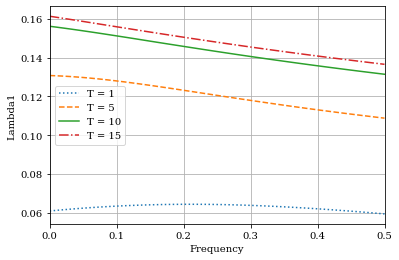

In [42]:
# freq1 = np.linspace(0, 0.5)
# time = [1, 5, 10, 15]
# lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
# sty = [':', '--', '-', '-.']
# for j in range(len(time)):
#     v = []
#     for i in freq1:
#         freq = [i, lamb[1]]
#         temp = rsmjd_gmmblamb_fst(S0, G, time[j], r, sigma, m, me, freq, mu, nu, A, Pi, N, X)[0]
#         v.append(temp)
#     plt.plot(freq1, v, label=lab[j], linestyle=sty[j])
# plt.legend()
# plt.xlabel('Frequency')
# plt.xlim((0, 0.5))
# plt.ylabel('Lambda1')
# plt.grid()

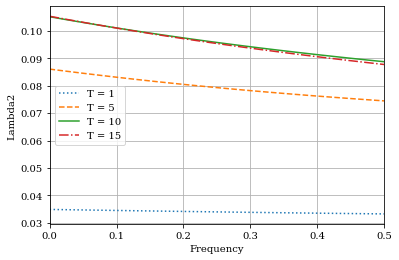

In [154]:
freq1 = np.linspace(0, 0.5, 20)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in freq1:
        freq = [i, lamb[1]]
        temp = rsmjd_gmmblamb_fst(S0, G, time[j], r, sigma, m, me, freq, mu, nu, A, Pi, N, X)[1]
        v.append(temp)
    plt.plot(freq1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Frequency')
plt.xlim((0, 0.5))
plt.ylabel('Lambda2')
plt.grid()

## Mu

In [5]:
def rsmjd_putmu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    mu1_p1 = ifft((-1j * w * lamb1 * np.exp(mu1 + 0.5 * nu1 ** 2) + 1j * w * lamb1 * np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2)) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    mu1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, mu1_p1)
    f2 = interpolate.PchipInterpolator(ST, mu1_p2)
    Mu1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    mu2_p1 = ifft(0 * fft(payoff_p)).real
    mu2_p2 = ifft((-1j * w * lamb2 * np.exp(mu2 + 0.5 * nu2 ** 2) + 1j * w * lamb2 * np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2)) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, mu2_p1)
    f2 = interpolate.PchipInterpolator(ST, mu2_p2)
    Mu2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Mu1_P), float(Mu2_P))
Results = rsmjd_putmu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X) 
print('Mu1_Put = %.16f' % Results[0]) # 0.1240430937983768
print('Mu2_Put = %.16f' % Results[1]) # -0.0000066462837324

Mu1_Put = 0.0000124055499348
Mu2_Put = -0.0664561910402236


In [6]:
def rsmjd_gmmbmu_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Mu1_P = rsmjd_putmu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Mu2_P = rsmjd_putmu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Mu1_Re = []
    Mu2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        mu1_re1 = ifft((-1j * w * lamb1 * np.exp(mu1 + 0.5 * nu1 ** 2) + 1j * w * lamb1 * np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2)) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        mu1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, mu1_re1)
        f2 = interpolate.PchipInterpolator(ST, mu1_re2)
        Mu1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method for sigma2
        mu2_re1 = ifft(0 * fft(payoff_r)).real
        mu2_re2 = ifft((-1j * w * lamb2 * np.exp(mu2 + 0.5 * nu2 ** 2) + 1j * w * lamb2 * np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2)) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, mu2_re1)
        f2 = interpolate.PchipInterpolator(ST, mu2_re2)
        Mu2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Mu1_Re = np.sum(Mu1_Re) / 100
    Mu2_Re = np.sum(Mu2_Re) / 100
    # calculate GMMB delta
    Mu1 = (s(T) * Mu1_P - Mu1_Re)
    Mu2 = (s(T) * Mu2_P - Mu2_Re)
    return (float(Mu1), float(Mu2))
Results = rsmjd_gmmbmu_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Mu1_GMMB = %.16f' % Results[0]) # 0.1209541993844647
print('Mu2_GMMB = %.16f' % Results[1]) # -0.0000052678462822

Mu1_GMMB = 0.0000120966296014
Mu2_GMMB = -0.0526731949763610


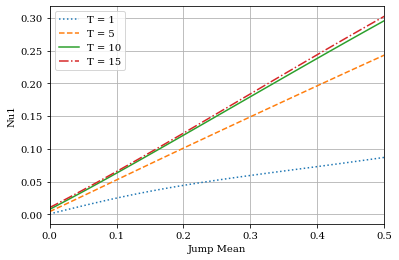

In [61]:
jmean1 = np.linspace(0, 0.5)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in jmean1:
        jmean = [i, mu[1]]
        temp = rsmjd_gmmbmu_fst(S0, G, time[j], r, sigma, m, me, lamb, jmean, nu, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(jmean1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Jump Mean')
plt.xlim((0, 0.5))
plt.ylabel('Nu1')
plt.grid()

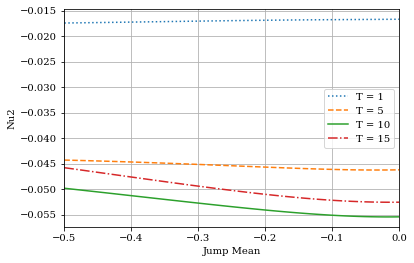

In [7]:
jmean1 = np.linspace(-0.5, 0)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in jmean1:
        jmean = [i, mu[1]]
        temp = rsmjd_gmmbmu_fst(S0, G, time[j], r, sigma, m, me, lamb, jmean, nu, A, Pi, N, X)[1]
        v.append(temp)
    plt.plot(jmean1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Jump Mean')
plt.xlim((-0.5, 0))
plt.ylabel('Nu2')
plt.grid()

## nu

In [62]:
def rsmjd_putnu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma 1
    nu1_p1 = ifft((-1j * w * lamb1 * nu1 * np.exp(mu1 + 0.5 * nu1 ** 2) - nu1 * w ** 2 * lamb1 * np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2)) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    nu1_p2 = ifft(0 * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, nu1_p1)
    f2 = interpolate.PchipInterpolator(ST, nu1_p2)
    Nu1_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    # FST method for sigma 2
    nu2_p1 = ifft(0 * fft(payoff_p)).real
    nu2_p2 = ifft((-1j * w * lamb2 * nu2 * np.exp(mu2 + 0.5 * nu2 ** 2) - nu2 * w ** 2 * lamb2 * np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2)) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, nu2_p1)
    f2 = interpolate.PchipInterpolator(ST, nu2_p2)
    Nu2_P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])) / 100
    return (float(Nu1_P), float(Nu2_P))
Results = rsmjd_putnu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X) 
print('Nu1_Put = %.16f' % Results[0]) # 0.0653933630392800
print('Nu2_Put = %.16f' % Results[1]) # 0.0000174966186302

Nu1_Put = 0.0653933630392800
Nu2_Put = 0.0000174966186302


In [63]:
def rsmjd_gmmbnu_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    Nu1_P = rsmjd_putnu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[0]
    Nu2_P = rsmjd_putnu_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)[1]
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Nu1_Re = []
    Nu2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method for sigma1
        nu1_re1 = ifft((-1j * w * lamb1 * nu1 * np.exp(mu1 + 0.5 * nu1 ** 2) - nu1 * w ** 2 * lamb1 * np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2)) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        nu1_re2 = ifft(0 * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, nu1_re1)
        f2 = interpolate.PchipInterpolator(ST, nu1_re2)
        Nu1_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method for sigma2
        nu2_re1 = ifft(0 * fft(payoff_r)).real
        nu2_re2 = ifft((-1j * w * lamb2 * nu2 * np.exp(mu2 + 0.5 * nu2 ** 2) - nu2 * w ** 2 * lamb2 * np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2)) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, nu2_re1)
        f2 = interpolate.PchipInterpolator(ST, nu2_re2)
        Nu2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Nu1_Re = np.sum(Nu1_Re) / 100
    Nu2_Re = np.sum(Nu2_Re) / 100
    # calculate GMMB delta
    Nu1 = (s(T) * Nu1_P - Nu1_Re)
    Nu2 = (s(T) * Nu2_P - Nu2_Re)
    return (float(Nu1), float(Nu2))
Results = rsmjd_gmmbnu_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Nu1_GMMB = %.16f' % Results[0]) # 0.0612250095375586
print('Nu2_GMMB = %.16f' % Results[1]) # 0.0000164011212354

Nu1_GMMB = 0.0612250095375753
Nu2_GMMB = 0.0000164011212354


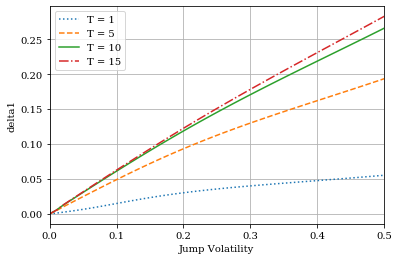

In [64]:
jvol1 = np.linspace(0, 0.5)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-', '-.']
for j in range(len(time)):
    v = []
    for i in jvol1:
        jvol = [i, nu[1]]
        temp = rsmjd_gmmbnu_fst(S0, G, time[j], r, sigma, m, me, lamb, mu, jvol, A, Pi, N, X)[0]
        v.append(temp)
    plt.plot(jvol1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Jump Volatility')
plt.xlim((0, 0.5))
plt.ylabel('delta1')
plt.grid()

## Alpha & Alpha^2

In [18]:
def rsmjd_gmmbmort_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    P = rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Alpha_Re = []
    Alpha2_Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        alpha_re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(b(t) * payoff_r)).real
        alpha_re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(b(t) * payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, alpha_re1)
        f2 = interpolate.PchipInterpolator(ST, alpha_re2)
        Alpha_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
        # FST method
        alpha2_re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(b(t) ** 2 * payoff_r)).real
        alpha2_re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(b(t) ** 2 * payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, alpha2_re1)
        f2 = interpolate.PchipInterpolator(ST, alpha2_re2)
        Alpha2_Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    # calculate GMMB mu
    Alpha = b(T) * s(T) * P - np.sum(Alpha_Re)
    Alpha2 = b(T) ** 2 * s(T) * P - np.sum(Alpha2_Re)
    return (float(Alpha), float(Alpha2)) # -124.7005713467245016

Results = rsmjd_gmmbmort_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
print('Alpha_GMMB = %.16f' % Results[0]) # -142.8589183054841953
print('Alpha2_GMMB = %.16f' % Results[1]) # 2723.2986109297653456

Alpha_GMMB = -142.8589183054841953
Alpha2_GMMB = 2723.2986109297653456


## Simulation

In [51]:
def rsmjd_gmmb_simulation(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, I):
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    l1, l2 = A[0, 1], A[1, 0]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    if Pi[0] > Pi[1]:
        Ini_State = 1.0
    else:
        Ini_State = 2.0
    F = np.zeros((T + 1, I))
    F[0] = S0
    for t in range(T + 1):
        for i in range(I):
            LogStock = float(np.log(S0))
            Cur_Time = 0.0
            Cur_State = Ini_State
            tau1 = 0.0
            while Cur_Time < t:
                p = npr.uniform(0, 1)
                if Cur_State == 1:
                    ExpRV = -1 * np.log(p) / l1
                else:
                    ExpRV = -1 * np.log(p) / l2
                if Cur_Time + ExpRV < t and Cur_State == 1:
                    tau1 = tau1 + ExpRV
                else:
                    if Cur_State == 1:
                        tau1 = tau1 + t - Cur_Time
                Cur_Time = Cur_Time + ExpRV
                if Cur_State == 1:
                    Cur_State = 2
                else:
                    Cur_State = 1
            J1 = 0
            Nt1 = npr.poisson(lamb1 * tau1)
            if Nt1 > 0:
                for j1 in range(Nt1):
                    J1 = J1 + npr.normal(mu1, nu1)
            J2 = 0
            Nt2 = npr.poisson(lamb2 * (t - tau1))
            if Nt2 > 0:
                for j2 in range(Nt2):
                    J2 = J2 + npr.normal(mu2, nu2)
            SimRand = float(npr.standard_normal())
            LogFund = LogStock + drift1 * tau1 + drift2 * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2) + J1 + J2
            F[t, i] = np.exp(LogFund)
    return F

Stock = rsmjd_gmmb_simulation(S0, G, T, drift, sigma, 0, lamb, mu, nu, A, Pi, Path)
Stock.shape

(11, 3)

In [36]:
# plt.figure(figsize=(10, 6))
# plt.plot(Stock[:, :])
# plt.xlabel('time')
# plt.ylabel('index level');

In [50]:
# for j in range(T+1):
#     Unhedged = []
#     for i in Stock[j]:
#         temp = rsmjd_gmmb_fst(i, G, T-j, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)k
#         Unhedged.append(temp)
#     print(j, np.mean(Unhedged), np.std(Unhedged))
#     if j == T:
#         aa = np.percentile(Unhedged, 5)
#         print('VaR_unhedged=', aa)
#         bb = [cc for cc in Unhedged if cc < aa]
#         print('CVaR_unhedged=', np.mean(bb))

0 3.481659405224491e-13 0.0
1 3.659635139216471 0.0
2 0.5633295138714836 0.0
3 3.1379005316898585 0.0
4 3.541517351339232 0.0
5 -0.9682778413420001 0.0
6 -11.18581411976507 0.0
7 -6.451861714192403 0.0
8 15.596028259588984 0.0
9 35.500826310145165 0.0
10 -1.8301296076754114e-14 0.0


## Static hedging by put options

In [19]:
# def portfolio_put(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
#     matrix = np.zeros((7, 8))
#     # GMMB(10) = Put(10 + Put(11) + Put(12) + f(10 + f(11) + Z(10) + Z(11)
#     matrix[0, 0] = rsmjd_gmmb_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     matrix[1, 0] = rsmjd_gmmbdelta_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     matrix[2, 0] = rsmjd_gmmbgamma_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     matrix[3, 0] = rsmjd_gmmbrho_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
#     matrix[4, 0] = rsmjd_gmmbvega_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
#     matrix[5, 0] = rsmjd_gmmbmort_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
#     matrix[6, 0] = rsmjd_gmmbmort_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[1]
#     for j in range(3): # Put(10), Put(11), Put(12)
#         matrix[0, j+1] = rsmjd_put_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
#         matrix[1, j+1] = rsmjd_putdelta_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
#         matrix[2, j+1] = rsmjd_putgamma_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
#         matrix[3, j+1] = rsmjd_putrho_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)[0]
#         matrix[4, j+1] = rsmjd_putvega_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)[0]
#     for j in range(2): # f(10), f(11), Z(10), Z(11)
#         matrix[0, j+4] = s(10+j) * z(r, t+j, A, Pi) # Price
#         matrix[3, j+4] = s(10+j) * rho1_z(r, t+j, A, Pi) # Rho1
#         matrix[5, j+4] = b(10+j) * s(10+j) * z(r, t+j, A, Pi) # Mu
#         matrix[6, j+4] = b(10+j) ** 2 * s(10+j) * z(r, t+j, A, Pi) # Mu2
#         matrix[0, j+6] = z(r, t+j, A, Pi) # Price
#         matrix[3, j+6] = rho1_z(r, t+j, A, Pi) # Rho1
#     weights = np.zeros((8))
#     weights[0] = -1
#     weights[1:] = lin.solve(matrix[:, 1:], matrix[:, 0])
#     return (matrix, weights)
# Results = portfolio_put(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
# print(Results)
# Matrix0 = Results[0]
# W_0 = Results[1]

(array([[ 2.87769808e-13,  1.07278022e+01,  1.09045949e+01,
         1.10325460e+01,  7.21721867e-01,  6.97643619e-01,
         7.78418037e-01,  7.61056976e-01],
       [-4.16271702e-01, -2.26362192e-01, -2.17628335e-01,
        -2.09388754e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.41774738e-03,  5.38122464e-03,  4.97786288e-03,
         4.63032146e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-4.11399360e+00, -3.33601451e+00, -3.59300191e+00,
        -3.83612935e+00, -7.21646548e-02, -7.67327893e-02,
        -7.78336802e-02, -8.37075306e-02],
       [ 5.10351925e-01,  5.38069468e-01,  5.47510579e-01,
         5.55583101e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.42858918e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.10261408e+01, -1.22615907e+01,
         0.00000000e+00,  0.00000000e+00],
       [ 2.72329861e+03,  0.00000

In [60]:
# def opt_weights(p):
#     w1, w2, w3, w4, w5, w6, w7 = p
#     matrix = Matrix0
#     weights = np.array([w1, w2, w3, w4, w5, w6, w7])
#     Bx = matrix[:, 1:].dot(weights)
#     C = matrix[:, 0]
#     return np.sum((Bx - C) ** 2)
# bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000)) 
# opt = sco.minimize(opt_weights, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], method='SLSQP', bounds=bnds)
# opt

     fun: 0.07006961589353183
     jac: array([-6.48777932e-05,  1.28471293e-04, -6.36382028e-05, -3.96743417e-07,
       -5.00120223e-07,  1.00507401e-04, -1.06805936e-04])
 message: 'Optimization terminated successfully.'
    nfev: 105
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([ -2.25472959,   0.19034841,   3.18033945,  -8.38398898,
        19.19016453, -13.44092331, -12.93929325])

In [61]:
# def reg_weights(p):
#     w1, w2, w3, w4, w5, w6, w7 = p
#     matrix = Matrix0
#     weights = np.array([w1, w2, w3, w4, w5, w6, w7])
#     Bx = matrix[:, 1:].dot(weights)
#     C = matrix[:, 0]
#     return (Bx - C).dot(Bx - C) + 10 * np.sum(np.abs(weights))

# bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000)) 
# reg = sco.minimize(reg_weights, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], method='SLSQP', bounds=bnds)
# reg

     fun: 274.01031952876787
     jac: array([-4.89931107, -6.87355804, -8.88809586, -1.45352173, -2.3730278 ,
       -7.86407471, -7.98972702])
 message: 'Optimization terminated successfully.'
    nfev: 253
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([-5.67600623e-01, -1.05275915e-02, -1.26579830e-07, -4.11664166e+00,
        1.58527835e+01, -1.46646925e-05, -1.19769883e-04])

In [64]:
# W_lin = W_0
# W_opt = np.hstack((np.array([-1]), opt.x))
# W_reg = np.hstack((np.array([-1]), reg.x))

[-1.00000000e+00 -2.34951128e+02  5.10785870e+02 -2.74900887e+02
 -8.38397657e+00  1.91901548e+01 -1.15304965e+03  1.14796998e+03]
[ -1.          -2.25472959   0.19034841   3.18033945  -8.38398898
  19.19016453 -13.44092331 -12.93929325]
[-1.00000000e+00 -5.67600623e-01 -1.05275915e-02 -1.26579830e-07
 -4.11664166e+00  1.58527835e+01 -1.46646925e-05 -1.19769883e-04]


In [ ]:
# def pv(S, t): # Present Value
#     vector = np.zeros(8)
#     vector[0] = rsmjd_gmmb_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     for j in range(3): # Put(10), Put(11), Put(12)
#         vector[j+1] = rsmjd_put_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
#     for j in range(2): # f(15), f(16), Z(15), Z(16)
#         vector[j+4] = s(10+j) * z(r, t+j, A, Pi)
#         vector[j+6] = z(r, t+j, A, Pi)
#     return vector

In [69]:
# for t in range(T+1):
#     Static = []
#     for i in Stock[t]:
#         pvt = pv(i, T-t)
#         Static.append(pvt.dot(W_lin))
#     print(t, np.mean(Static), np.std(Static))

0 -4.860044555243803e-06 0.0
1 -1.133954422995051 0.21082945788161267
2 -1.841037191794688 0.109269243547751
3 -3.653991727136751 0.5712167483219852
4 -10.204862614317411 0.8147536013817026
5 -11.746930416669462 6.468484454544427
6 -15.64039334627038 10.975689328243924
7 -29.982027061891547 15.216688639220731
8 -34.29391555156443 24.548259026096638
9 -69.28043372759129 24.62462424005334
10 -220.28077962777738 124.93907804273519


In [70]:
# for t in range(T+1):
#     Static = []
#     for i in Stock[t]:
#         pvt = pv(i, T-t)
#         Static.append(pvt.dot(W_opt))
#     print(t, np.mean(Static), np.std(Static))

0 0.0014117206304753438 0.0
1 -0.8752960841830104 1.8815455502473575
2 -4.133820779239937 0.8580045768028903
3 -0.7155853333461136 0.6955079246163607
4 1.0256151466026455 0.3945418376374683
5 -5.200402017450325 5.012244523584261
6 -3.2551638161623564 1.2977446677929156
7 -9.126715016577153 7.170158117629747
8 -7.222437389927023 0.9415320280731048
9 -11.385061546461563 1.160291562640025
10 -20.09316801943061 7.433244573207938


In [71]:
# for t in range(T+1):
#     Static = []
#     for i in Stock[t]:
#         pvt = pv(i, T-t)
#         Static.append(pvt.dot(W_reg))
#     print(t, np.mean(Static), np.std(Static))

0 1.884616602462916 0.0
1 1.7696467251380577 4.8450139783522905
2 -4.790359368753637 2.521443338556888
3 7.363875466539182 1.9416162895751359
4 15.629254295626035 1.1336732562734364
5 -0.1640397663189835 16.323665398541458
6 10.720373134195261 6.72685977805205
7 -5.472120641019937 23.6028165275854
8 10.08430607138372 6.458893564747413
9 12.648385776258522 0.5763600064978549
10 -9.378339354337816 19.403038652584893


## Static hedging by call options

In [70]:
# def portfolio_call(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
#     matrix = np.zeros((7, 8))
#     # GMMB(10) = Put(10 + Put(11) + Put(12) + f(10 + f(11) + Z(10) + Z(11)
#     matrix[0, 0] = rsmjd_gmmb_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     matrix[1, 0] = rsmjd_gmmbdelta_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     matrix[2, 0] = rsmjd_gmmbgamma_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     matrix[3, 0] = rsmjd_gmmbrho_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
#     matrix[4, 0] = rsmjd_gmmbvega_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
#     matrix[5, 0] = rsmjd_gmmbmort_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
#     matrix[6, 0] = rsmjd_gmmbmort_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[1]
#     for j in range(3): # Put(10), Put(11), Put(12)
#         matrix[0, j+1] = rsmjd_call_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
#         matrix[1, j+1] = rsmjd_calldelta_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
#         matrix[2, j+1] = rsmjd_callgamma_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
#         matrix[3, j+1] = rsmjd_callrho_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)[0]
#         matrix[4, j+1] = rsmjd_callvega_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)[0]
#     for j in range(2): # f(10), f(11), Z(10), Z(11)
#         matrix[0, j+4] = s(10+j) * z(r, t+j, A, Pi) # Price
#         matrix[3, j+4] = s(10+j) * rho1_z(r, t+j, A, Pi) # Rho1
#         matrix[5, j+4] = b(10+j) * s(10+j) * z(r, t+j, A, Pi) # Mu
#         matrix[6, j+4] = b(10+j) ** 2 * s(10+j) * z(r, t+j, A, Pi) # Mu2
#         matrix[0, j+6] = z(r, t+j, A, Pi) # Price
#         matrix[3, j+6] = rho1_z(r, t+j, A, Pi) # Rho1
#     weights = np.zeros((8))
#     weights[0] = -1
#     weights[1:] = lin.solve(matrix[:, 1:], matrix[:, 0])
#     return (matrix, weights)
# Results = portfolio_call(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
# print(Results)
# Matrix0 = Results[0]
# W_0 = Results[1]

(array([[ 2.87769808e-13,  3.28859981e+01,  3.47988970e+01,
         3.66238142e+01,  7.21721867e-01,  6.97643619e-01,
         7.78418037e-01,  7.61056976e-01],
       [-4.16271702e-01,  7.73637808e-01,  7.82371665e-01,
         7.90611246e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.41774738e-03,  5.38122464e-03,  4.97786288e-03,
         4.63032146e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-4.11399360e+00,  4.44735351e+00,  4.77775116e+00,
         5.09198657e+00, -7.21646548e-02, -7.67327893e-02,
        -7.78336802e-02, -8.37075306e-02],
       [ 5.10351925e-01,  5.38069468e-01,  5.47510579e-01,
         5.55583102e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.42858918e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.10261408e+01, -1.22615907e+01,
         0.00000000e+00,  0.00000000e+00],
       [ 2.72329861e+03,  0.00000

In [76]:
# def opt_weights(p):
#     w1, w2, w3, w4, w5, w6, w7 = p
#     matrix = Matrix0
#     weights = np.array([w1, w2, w3, w4, w5, w6, w7])
#     Bx = matrix[:, 1:].dot(weights)
#     C = matrix[:, 0]
#     return np.sum((Bx - C) ** 2)
# bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000)) 
# opt = sco.minimize(opt_weights, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], method='SLSQP', bounds=bnds)
# opt

     fun: 0.45705202868828754
     jac: array([ 1.41009688e-04, -3.71925533e-04,  1.34389848e-04,  1.90217048e-04,
        2.42978334e-04,  2.67960131e-05, -3.13147902e-05])
 message: 'Optimization terminated successfully.'
    nfev: 114
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([ 3.99547342e+00, -8.72234776e-03, -3.97262607e+00, -8.38395938e+00,
        1.91901414e+01,  4.52732595e+00,  4.65190691e+00])

In [78]:
# def reg_weights(p):
#     w1, w2, w3, w4, w5, w6, w7 = p
#     matrix = Matrix0
#     weights = np.array([w1, w2, w3, w4, w5, w6, w7])
#     Bx = matrix[:, 1:].dot(weights)
#     C = matrix[:, 0]
#     return (Bx - C).dot(Bx - C) + 10 * np.sum(np.abs(weights))

# bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000)) 
# reg = sco.minimize(reg_weights, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], method='SLSQP', bounds=bnds)
# reg

     fun: 244.41915532327835
     jac: array([ 3.6127491 ,  4.7108345 ,  5.75557518, -0.02344704, -0.22114182,
        9.57463837,  9.55274391])
 message: 'Optimization terminated successfully.'
    nfev: 460
     nit: 39
    njev: 39
  status: 0
 success: True
       x: array([-2.38621843e-07, -7.32288732e-02, -1.53534904e-01, -4.02971641e+00,
        1.57848519e+01,  3.98007094e-04,  1.22267482e-04])

In [ ]:
# W_lin = W_0
# W_opt = np.hstack((np.array([-1]), opt.x))
# W_reg = np.hstack((np.array([-1]), reg.x))

In [ ]:
# def pv(S, t): # Present Value
#     vector = np.zeros(8)
#     vector[0] = rsmjd_gmmb_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
#     for j in range(3): # Put(10), Put(11), Put(12)
#         vector[j+1] = rsmjd_call_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
#     for j in range(2): # f(15), f(16), Z(15), Z(16)
#         vector[j+4] = s(10+j) * z(r, t+j, A, Pi)
#         vector[j+6] = z(r, t+j, A, Pi)
#     return vector

In [ ]:
# for t in range(T+1):
#     Static = []
#     for i in Stock[t]:
#         pvt = pv(i, T-t)
#         Static.append(pvt.dot(W_lin))
#     print(t, np.mean(Static), np.std(Static))

In [ ]:
0 0.00020894496901746606 0.0
1 -1.1846010991004214 1.9336380269410987
2 -2.1220876847478927 6.24561930201236
3 -2.5612668942196857 11.982641186989493
4 -2.7991223257245434 21.080841431612956
5 -1.3537674899472094 35.819562704767925
6 7.382313026439134 62.19600043963617
7 13.52468494213832 101.3387538750435
8 42.49111765255375 168.06535021460445
9 103.42195893730842 316.3891411954494
10 232.86932535455634 762.1301291715027

In [ ]:
# for t in range(T+1):
#     Static = []
#     for i in Stock[t]:
#         pvt = pv(i, T-t)
#         Static.append(pvt.dot(W_opt))
#     print(t, np.mean(Static), np.std(Static))

In [ ]:
0 0.0004112648800269625 0.0
1 -0.16548478068585804 5.216062588436887
2 -0.07660082585101335 7.785517178330867
3 -0.9496620625170281 9.69020419638168
4 -1.9250846632122218 10.965760014956146
5 -3.138548638618413 11.637844743519995
6 -4.507968763427783 12.938668850664017
7 -6.275020252301816 13.000442547843555
8 -7.562833725239882 12.431797241091507
9 -10.085786055506667 12.220744528307778
10 -13.224663671790779 10.354979181413682

In [ ]:
# for t in range(T+1):
#     Static = []
#     for i in Stock[t]:
#         pvt = pv(i, T-t)
#         Static.append(pvt.dot(W_reg))
#     print(t, np.mean(Static), np.std(Static))

In [ ]:
0 -0.06745105971543808 0.0
1 -0.18326159109945744 3.204826327921282
2 -0.38161289220237565 4.70596459899086
3 -1.306531108680942 6.12994211034135
4 -2.325738506527834 7.61419927150092
5 -3.319644296255522 8.892625879083194
6 -5.22196630064464 11.174277591755502
7 -7.0580542680263045 12.959737634599358
8 -8.110983472958408 14.247450097683231
9 -11.461549395715858 17.379487663217038
10 -13.492346478144805 19.283272061838627

## Semi-static hedging by put options

In [69]:
W_lin = np.array([-1.00000000e+00, -2.34951128e+02,  5.10785870e+02, -2.74900887e+02,
                  -8.38397657e+00,  1.91901548e+01, -1.15304965e+03,  1.14796998e+03])
W_opt = np.array([ -1.        ,  -2.25472959,   0.19034841,   3.18033945,
                   -8.38398898,  19.19016453, -13.44092331, -12.93929325])
W_reg = np.array([-1.00000000e+00, -5.67600623e-01, -1.05275915e-02, -1.26579830e-07,
                  -4.11664166e+00,  1.58527835e+01, -1.46646925e-05, -1.19769883e-04])

def matrix_put(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    matrix = np.zeros((7, 8))
    # GMMB(10) = Put(10 + Put(11) + Put(12) + f(10 + f(11) + Z(10) + Z(11)
    matrix[0, 0] = rsmjd_gmmb_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
    matrix[1, 0] = rsmjd_gmmbdelta_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
    matrix[2, 0] = rsmjd_gmmbgamma_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
    matrix[3, 0] = rsmjd_gmmbrho_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
    matrix[4, 0] = rsmjd_gmmbvega_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
    matrix[5, 0] = rsmjd_gmmbmort_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
    matrix[6, 0] = rsmjd_gmmbmort_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[1]
    for j in range(3): # Put(10), Put(11), Put(12)
        matrix[0, j+1] = rsmjd_put_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
        matrix[1, j+1] = rsmjd_putdelta_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
        matrix[2, j+1] = rsmjd_putgamma_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
        matrix[3, j+1] = rsmjd_putrho_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)[0]
        matrix[4, j+1] = rsmjd_putvega_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)[0]
    for j in range(2): # f(10), f(11), Z(10), Z(11)
        matrix[0, j+4] = s(10+j) * z(r, t+j, A, Pi) # Price
        matrix[3, j+4] = s(10+j) * rho1_z(r, t+j, A, Pi) # Rho1
        matrix[5, j+4] = b(10+j) * s(10+j) * z(r, t+j, A, Pi) # Mu
        matrix[6, j+4] = b(10+j) ** 2 * s(10+j) * z(r, t+j, A, Pi) # Mu2
        matrix[0, j+6] = z(r, t+j, A, Pi) # Price
        matrix[3, j+6] = rho1_z(r, t+j, A, Pi) # Rho1
    return matrix

Weights = np.zeros((T+1, Path, 8)) # (Weights4, Weights8, Weights12) * scenario * 8
Weights[0] = W_reg
for t in [2, 4, 6, 8]:
    stock = Stock[t]
    for i in range(len(stock)):
        Matrix = matrix_put(stock[i], G, T-t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
        def reg_weights(p):
            w1, w2, w3, w4, w5, w6, w7 = p
            matrix = Matrix
            weights = np.array([w1, w2, w3, w4, w5, w6, w7])
            Bx = matrix[:, 1:].dot(weights)
            C = matrix[:, 0]
            return (Bx - C).dot(Bx - C) + 10 * np.sum(np.abs(weights))
        bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000)) 
        temp = sco.minimize(reg_weights, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], method='SLSQP', bounds=bnds).x
        Weights[t, i] = np.hstack((np.array([-1]), temp))

def pv(S, t): # Present Value
    vector = np.zeros(8)
    vector[0] = rsmjd_gmmb_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
    for j in range(3): # Put(10), Put(11), Put(12)
        vector[j+1] = rsmjd_put_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
    for j in range(2): # f(15), f(16), Z(15), Z(16)
        vector[j+4] = s(10+j) * z(r, t+j, A, Pi)
        vector[j+6] = z(r, t+j, A, Pi)
    return vector

for t in range(T + 1):
# for t in range(0, 6):
    Semi = []
    if t < 2:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[0, i]))
    elif 2 <= t < 4:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[2, i]))
    elif 4 <= t < 6:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[4, i]))
    elif 6 <= t < 8:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[6, i]))
    elif 8 <= t:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[8, i]))
    print(t, np.mean(Semi), np.std(Semi))

0 1.8845126389989797 0.0
1 6.734612257504928 3.4537838524943862
2 2.796289027117853 0.8388956654729898
3 -15.239925980707731 26.05450455839762
4 1.6181676652598014 0.4856754876519961
5 4.254188438299399 4.647405566096462
6 1.8326820302125917 2.734168105601326
7 -2.1937246766815313 14.456481706320893
8 3.602316597911582 2.653820594415248
9 6.14756517150292 3.81633159794276
10 -0.2527937519977736 0.7578204787865593


## Semi-static hedging by call options

In [80]:
W_lin = np.array([-1.00000000e+00, -1.24244157e+03,  2.68904261e+03, -1.44577660e+03,
       -8.38397657e+00,  1.91901548e+01,  7.89591752e+03, -7.77943525e+03])
W_opt = np.array([-1.00000000e+00,  3.99547342e+00, -8.72234776e-03, -3.97262607e+00,
       -8.38395938e+00,  1.91901414e+01,  4.52732595e+00,  4.65190691e+00])
W_reg = np.array([-1.00000000e+00, -2.38621843e-07, -7.32288732e-02, -1.53534904e-01,
       -4.02971641e+00,  1.57848519e+01,  3.98007094e-04,  1.22267482e-04])

def matrix_call(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    matrix = np.zeros((7, 8))
    # GMMB(10) = Put(10 + Put(11) + Put(12) + f(10 + f(11) + Z(10) + Z(11)
    matrix[0, 0] = rsmjd_gmmb_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
    matrix[1, 0] = rsmjd_gmmbdelta_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
    matrix[2, 0] = rsmjd_gmmbgamma_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
    matrix[3, 0] = rsmjd_gmmbrho_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
    matrix[4, 0] = rsmjd_gmmbvega_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
    matrix[5, 0] = rsmjd_gmmbmort_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[0]
    matrix[6, 0] = rsmjd_gmmbmort_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)[1]
    for j in range(3): # Put(10), Put(11), Put(12)
        matrix[0, j+1] = rsmjd_call_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
        matrix[1, j+1] = rsmjd_calldelta_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
        matrix[2, j+1] = rsmjd_callgamma_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
        matrix[3, j+1] = rsmjd_callrho_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)[0]
        matrix[4, j+1] = rsmjd_callvega_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)[0]
    for j in range(2): # f(10), f(11), Z(10), Z(11)
        matrix[0, j+4] = s(10+j) * z(r, t+j, A, Pi) # Price
        matrix[3, j+4] = s(10+j) * rho1_z(r, t+j, A, Pi) # Rho1
        matrix[5, j+4] = b(10+j) * s(10+j) * z(r, t+j, A, Pi) # Mu
        matrix[6, j+4] = b(10+j) ** 2 * s(10+j) * z(r, t+j, A, Pi) # Mu2
        matrix[0, j+6] = z(r, t+j, A, Pi) # Price
        matrix[3, j+6] = rho1_z(r, t+j, A, Pi) # Rho1
    return matrix

Weights = np.zeros((T+1, Path, 8)) # (Weights4, Weights8, Weights12) * scenario * 8
Weights[0] = W_reg
for t in [2, 4, 6, 8]:
    stock = Stock[t]
    for i in range(len(stock)):
        Matrix = matrix_call(stock[i], G, T-t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
        def reg_weights(p):
            w1, w2, w3, w4, w5, w6, w7 = p
            matrix = Matrix
            weights = np.array([w1, w2, w3, w4, w5, w6, w7])
            Bx = matrix[:, 1:].dot(weights)
            C = matrix[:, 0]
            return (Bx - C).dot(Bx - C) + 10 * np.sum(np.abs(weights))
        bnds = ((-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000), (-1000, 1000)) 
        temp = sco.minimize(reg_weights, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], method='SLSQP', bounds=bnds).x
        Weights[t, i] = np.hstack((np.array([-1]), temp))

def pv(S, t): # Present Value
    vector = np.zeros(8)
    vector[0] = rsmjd_gmmb_fst(S, G, t, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X)
    for j in range(3): # Put(10), Put(11), Put(12)
        vector[j+1] = rsmjd_call_fst(S, G, t+j, r, sigma, 0, lamb, mu, nu, A, Pi, N, X)
    for j in range(2): # f(15), f(16), Z(15), Z(16)
        vector[j+4] = s(10+j) * z(r, t+j, A, Pi)
        vector[j+6] = z(r, t+j, A, Pi)
    return vector

for t in range(T + 1):
# for t in range(0, 6):
    Semi = []
    if t < 2:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[0, i]))
    elif 2 <= t < 4:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[2, i]))
    elif 4 <= t < 6:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[4, i]))
    elif 6 <= t < 8:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[6, i]))
    elif 8 <= t:
        stock = Stock[t]
        for i in range(len(stock)):
            pvt = pv(stock[i], T-t)
            Semi.append(pvt.dot(Weights[8, i]))
    print(t, np.mean(Semi), np.std(Semi))

0 -0.06705603861563247 0.0
1 1.7168348255168004 1.2930846151810902
2 -0.011021154961543544 0.024825781666139374
3 -6.65165351778736 5.628128975947927
4 -0.052659797062752034 0.06651342400495519
5 1.7514101240918414 2.577332484164636
6 -0.3459655357359241 0.5323521832359469
7 15.574831098596723 37.20515609837947
8 -1.1852997986761176 1.7524532789000953
9 444.61909900429254 636.5526838604333
10 -7.827317540251333 1.0473089412000456
